# TD3: Vision Transformer (ViT)

In this TD, you must modify this notebook to complete the code (**# TO DO comments**) and complete the **proposed experiments**. To do this,

1. Fork this repository
2. Clone your forked repository on your local computer
3. Add your code and answer the questions
4. Commit and push regularly

**The last commit is due on Sunday, 14th January 2024**. Later commits will not be taken into account.

As the computation is heavy, particularly during training, we encourage you to use a GPU. If your laptob is not equiped, you may use one of these remote jupyter servers, where you can select the execution on GPU :

1) [jupyter.mi90.ec-lyon.fr](https://jupyter.mi90.ec-lyon.fr/)

This server is accessible within the campus network. If outside, you need to use a VPN. Before executing the notebook, select the kernel "Python PyTorch" to run it on GPU and have access to PyTorch module.

2) [Google Colaboratory](https://colab.research.google.com/)

Before executing the notebook, select the execution on GPU : "Exécution" Menu -> "Modifier le type d'exécution" and select "T4 GPU". 

> #### Student: Victor Ludvig, December 2023

> I am using a personal jupyter server through ssh tunneling that is running on a PC with 2 gpus.

In [7]:
!nvidia-smi

Fri Dec  1 17:29:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8              34W / 420W |    189MiB / 24576MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Goal of the TD

Transformers have been introduced by [Vaswani et al. in 2017](https://arxiv.org/abs/1706.03762) in the context of NLP (Natural Language Processing), and particulary for Machine Translation.

Its great success has led to its adaptation to various applications, including image classification. In this trend, [Dosovitskiy et al. in 2020](https://arxiv.org/abs/2010.11929) have proposed Vision Transformers (ViT) that we will study and implement from scratch in this TD.

The principle is illustrated in the following picture from this paper.

![Vision Tranformers](./figures/vit.png "Vision Transformers")

First, an input image is “cut” into sub-images equally sized.

Each such sub-image goes through a linear embedding. From then, each sub-image becomes a one-dimensional vector.

A positional embedding is then added to these vectors (tokens). The positional embedding allows the network to know where each sub-image is positioned originally in the image. Without this information, the network would not be able to know where each such image would be placed, leading to potentially wrong predictions.

These tokens are then passed, together with a special classification token, to the transformer encoders blocks, were each is composed of : A Layer Normalization (LN), followed by a Multi-head Self Attention (MSA) and a residual connection. Then a second LN, a Multi-Layer Perceptron (MLP), and again a residual connection. These blocks are connected back-to-back.

Finally, a classification MLP head is used for the final classification only on the special classification token, which by the end of this process has global information about the picture.


### Implementation of the ViT model

First, we import the required modules.

> I used tqdm to monitor progress of training. <br>
> It can be installed with the following line:

In [32]:
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 3.1 MB/s eta 0:00:00


In [15]:
# Import modules
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from read_cifar import read_cifar
from read_cifar import split_dataset
import time
import copy

For this first experiment, we will use the MNIST dataset that contains 28x28 binary pixels images of hand-written digits ([0–9]).

In [28]:
# Load data
transform = ToTensor()

train_set = MNIST(
    root="datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

### "Patchification"
The transformer encoder was originally developed with sequence data in mind, such as English sentences. However, as an image is not a sequence, we need to “sequencify” an image. To do this, we break it into multiple sub-images and map each sub-image to a vector.

We do so by simply reshaping our input, which has size (N, C, H, W), where N is the batch size, C the number of channels and (H,W) the image dimension. In the case of MNIST, dimensions are (N, 1, 28, 28). The target dimension is (N, #Patches, Patch dimensionality), where the dimensionality of a patch is adjusted accordingly.

In this example, we break each (1, 28, 28) into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.

Thus, we reshape input (N, 1, 28, 28) to (N, PxP, Cx(H/P)x(W/P)) = (N, 49, 16)

Notice that, while each patch is a picture of size 1x4x4, we flatten it to a 16-dimensional vector. Also, in this case, we only had a single color channel. If we had multiple color channels, those would also have been flattened into the vector.

> I added choice of device, with default value to first gpu.

In [2]:
def patchify(images, n_patches, device='cuda:0'):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        # division of the image into patches
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                # Add the corresponding patch for the idx-th image
                # Order is defined here, we could define an other order
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches.to(device)

### Linear embedding

Now that we have our flattened patches, we can map each of them through a Linear mapping. While each patch was a 4x4=16 dimensional vector, the linear mapping can map to any arbitrary vector size. Thus, we will use for this a parameter `hidden_d` for "hidden dimension".

In this example, we will use a hidden dimension of 8, but in principle, any number can be put here. We will thus be mapping each 16-dimensional patch to an 8-dimensional patch.


### Positional encoding

Positional encoding allows the model to understand where each patch would be placed in the original image. While it is theoretically possible to learn such positional embeddings, previous work by [Vaswani et al. in 2017](https://arxiv.org/abs/1706.03762) suggests that we can just add sines and cosines waves.

In particular, positional encoding adds high-frequency values to the first dimensions and lower-frequency values to the latter dimensions.

In each sequence, for token i we add to its j-th coordinate the following value:

![Positional encoding](./figures/positional_encoding.png "Positional encoding").

This positional embedding is a function of the number of elements in the sequence and the dimensionality of each element. Thus, it is always a 2-dimensional tensor or “rectangle”.

Here is a simple function that, given the number of tokens and the dimensionality of each of them, outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.

This positional encoding is added to our model after the linear mapping and the addition of the class token.

>_Personal Note_: This function works because of how the patching process is implemented. Positions of patches inside of an image are grouped by columns, that's why we check j%2, to know in which column the patch is. <br>
>We start with j-1 in the is to have an odd value like in the cos(?). <br>
>We should probably change the denominator 10.000 because our vectors are much smaller (8-dimensional vectors), vs 256 in the original paper. <br>

In [3]:
def get_positional_embeddings(sequence_length, d):
    """ 
    Personal note.
    sequence length: number of images
    d: number of pathes for each image
    """
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

### Multi-Head Self-Attention

The objective is now that, for a single image, each patch has to be updated based on some similarity measure with the other patches. We do so by linearly mapping each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: q, k, and v (query, key, value).

Then, for a single patch, we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimensionality of these vectors (sqrt(8)), softmax these so-called attention cues, and finally multiply each attention cue with the v vectors associated with the different k vectors and sum all up.

In this way, each patch assumes a new value that is based on its similarity (after the linear mapping to q, k, and v) with other patches. This whole procedure, however, is carried out H times on H sub-vectors of our current 8-dimensional patches, where H is the number of Heads. 

Once all results are obtained, they are concatenated together. Finally, the result is passed through a linear layer (for good measure).

The intuitive idea behind attention is that it allows modeling the relationship between the inputs. What makes a ‘0’ a zero are not the individual pixel values, but how they relate to each other.

This is implemented in the MSA class.

#### Personal note: explanation of the attention computation. <br>
> *Formula if inputs are contained in columns* <br>
>Considering the i-th head, the matrices of queries, keys and values are noted Q, K, V. <br>
>The dimension of an individual query, key, or value is H. <br>
>These matrices contain the queries and keys on the columns (in the course, not in pratice). <br>
>The matrix $D$ with dot product of the j-th query on the j-th row ($D_{ij} = k_i.q_j = \alpha_{ji}$) is thus $D=K^TQ$. <br>
>Softmax is then applied on the columns of the matrix (dim=0), and the matrix is divided element-wise by $\sqrt H$. <br>
>Multiplying on the left with the values matrix yields the matrix of attentions on each column:
>$\begin{equation}
>Attention(Q,K,V)= Vsoftmax(\frac{K^TQ}{\sqrt H}) \end{equation}$
> *Formula if inputs are contained in lines* <br>
>In machine learning, input feature vectors are line vectors, not column vectors. <br>
> Hence, the queries, keys and values are contained in the lines of Q, K, V. <br>
> With this configuration, the dot product matrix $D=QK^T$ yields: $D_{ij}=q_i.k_j$ <br>
> Taking the softmax on the line (dim=1) and multiplying on the right with the line values matrix yields the new attention line matrix:
> $\begin{equation}
Attention(Q,K,V)= softmax(\frac{QK^t}{\sqrt H})V \end{equation}$
The second equation is the equation of the original attention paper.

In [4]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super().__init__()
        # PN: dimension of a patch
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        # PN: A head will process a subvector of a patch
        # PN: The dimension of the input vector will thus be d/n_heads
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        """ 
        sequences: flattened and linearly projected images
        """
        # Sequences has shape (N, seq_length, token_dim) = (N_images, size_image, size_patch)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                # PN: q,k,v are vectors of shape (head,1).
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                # PN: sequence are the patches of the i-th flattened image
                # For all patches, we are going to apply the attention to a subpart of the patch
                # Thus we consider all patches (:), and the subpart of size self.d_head (8/2=4 in our example)
                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                Q, K, V = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                #
                # TO DO: implement attention computation
                #
                attention = torch.matmul(F.softmax(torch.matmul(Q, K.T)/math.sqrt(self.d_head), dim=1), V)

                seq_result.append(attention)
                
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

Notice that, for each head, we create distinct Q, K, and V mapping functions (square matrices of size 4x4 in our example).

Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

Also notice that using loops is not the most efficient way to compute the multi-head self-attention, but it makes the code much clearer for learning.

### Transformer Encoder Blocks

The next step is to create the transformer encoder block class.

Layer normalization (LN) is a popular block that, given an input, subtracts its mean and divides by the standard deviation. It is applied to the last dimension only. We can thus make each of our 50x8 matrices (representing a single sequence) have mean 0 and std 1. After we run our (N, 50, 8) tensor through LN, we still get the same dimensionality.

Also, We will be using residual connection that consists in adding the original input to the result of some computation. This, intuitively, allows a network to become more powerful while also preserving the set of possible functions that the model can approximate.

We will add a residual connection that will add our original (N, 50, 8) tensor to the (N, 50, 8) obtained after LN and MSA. 

Next is to add a simple residual connection between what we already have and what we get after passing the current tensor through another LN and an MLP. The MLP is composed of two layers, where the hidden layer typically is four times as big (this is a parameter).

The transformer encoder block class (which will be a component of the future ViT class) is thus as follows:

In [5]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super().__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        #
        # TO DO: implement the forward pass
        #
        # I used the walrus operator (:=) to compress the code
        out = (p := x + self.mhsa(self.norm1(x))) + self.mlp(self.norm2(p))
        
        return out

### ViT model

Now that the encoder block is ready, we just need to insert it in our bigger ViT model which is responsible for patchifying before the transformer blocks, and carrying out the classification after.

To help classification, we will use an additional **classification token** to the input sequence. This is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block. When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

Thus, we will add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

We could have an arbitrary number of transformer blocks. In this example, to keep it simple, I will use only 2. We also add a parameter to know how many heads does each encoder block will use.

Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.

Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.

The output of our model shoud be an (N, 10) tensor. 

In [6]:
class ViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super().__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])

        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        #
        # TO DO: implement the forward pass
        #

        # Dividing images into patches
        n, c, h, w = images.shape

        patches = patchify(images, self.n_patches)
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
        

        # Getting the classification token only
        out = out[:,0,:]

        # Map to output dimension, output category distribution
        
        out =  self.mlp(out)
        

        return out  

### ViT training

The ViT model being built, the next step is to train it on the MNIST dataset.

First, we initialize the model and the hyperparameters.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

model = ViT(
    (1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
).to(device)

N_EPOCHS = 5
LR = 0.005

optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

Using device:  cuda (NVIDIA GeForce RTX 3090)


Training of the ViT model:
> I changed the code to a function so that it can be used with the 4-heads version of the model later.

In [13]:
def train(model, optimizer, criterion, train_loader, N_EPOCHS):
    train_losses = []
    train_accuracies = []
    
    for epoch in tqdm(range(N_EPOCHS)):
        train_loss = 0.0
        count_correct_pred = 0
        count_elem = 0
        for i, batch in enumerate(train_loader):
            x, y = batch
            count_elem += len(y)
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()

            y_hat = model(x)
            loss = criterion(y_hat, y)
            train_loss += loss.detach().cpu().item() / len(train_loader)

            with torch.no_grad():
                _, pred = torch.max(y_hat, 1)
                count_correct_pred += sum(pred.eq(y).cpu().numpy())

            #
            # TO DO : implement the gradients computation and the parameters update
            #
            # I also added optimizer.zero_grad() above
            loss.backward()
            optimizer.step()      

        train_losses.append(train_loss)
        running_accuracy = (count_correct_pred/count_elem)
        train_accuracies.append(running_accuracy)
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}, accuracy: {running_accuracy:.2f}")
    return train_losses, train_accuracies

In [14]:
train_losses, train_accuracies = train(model, optimizer, criterion, train_loader, N_EPOCHS)

 20%|████████████████████████▍                                                                                                 | 1/5 [01:20<05:23, 80.99s/it]

Epoch 1/5 loss: 2.11, accuracy: 0.33


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [02:42<04:03, 81.18s/it]

Epoch 2/5 loss: 1.95, accuracy: 0.51


 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [04:02<02:41, 80.88s/it]

Epoch 3/5 loss: 1.81, accuracy: 0.65


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [05:23<01:20, 80.76s/it]

Epoch 4/5 loss: 1.75, accuracy: 0.71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:43<00:00, 80.80s/it]

Epoch 5/5 loss: 1.73, accuracy: 0.73


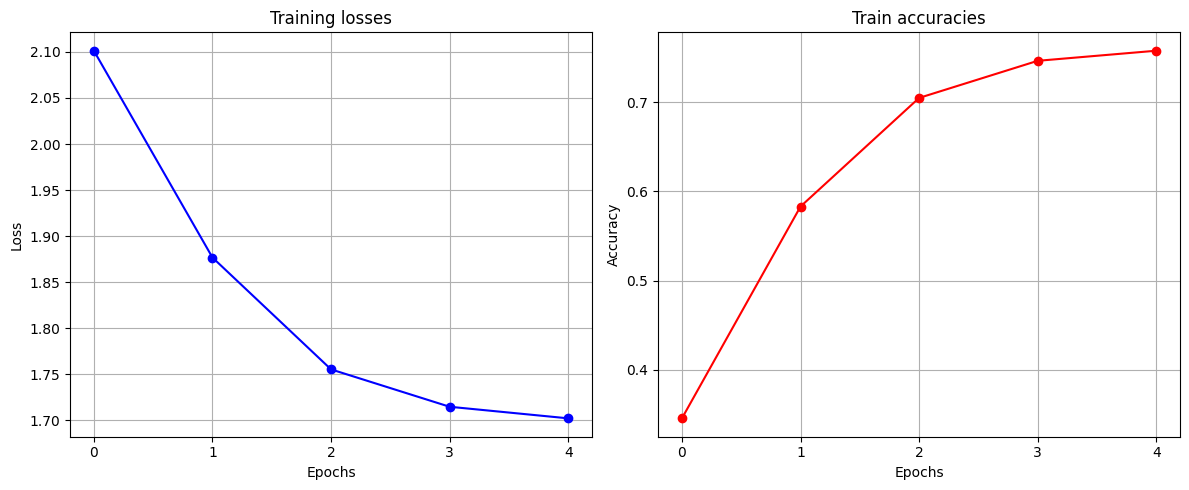

<Figure size 640x480 with 0 Axes>

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(N_EPOCHS), train_losses, marker='o', linestyle='-', color='b')
ax1.set_title('Training losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xticks(np.arange(0,N_EPOCHS,1))
ax1.grid(True)

ax2.plot(range(N_EPOCHS), train_accuracies, marker='o', linestyle='-', color='r')
ax2.set_title('Train accuracies')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(np.arange(0,N_EPOCHS,1))
ax2.grid(True)

plt.tight_layout()

# Show the plot
plt.show()  
plt.savefig('figures/vit_training_1.png')

>The Transformer model is able to learn. <br>
>It seems the number of epochs could be increased. <br>
>I will increase it for the 4-head version.

### ViT test

Finally, let's test the trained model.

In [24]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in test_loader:
            x, y = batch
            total += len(y)
            x, y = x.to(device), y.to(device)

            #
            # TO DO: implement the computation of the loss and the accuracy (correct)
            # 
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(train_loader)

            _, pred = torch.max(y_hat, 1)
            correct += sum(pred.eq(y).cpu().numpy())
        

        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        return test_loss, correct/total

In [25]:
test_loss, test_accuracy = test(model, test_loader)

Test loss: 0.29
Test accuracy: 73.05%


#### Test examples
> I run the model on batch of 16 images from the test set and plot de results in a 4x4 grid

In [41]:
def show_images(images, titles):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(len(axs)):
        for j, ax in enumerate(axs[i]):
            ax.imshow(np.transpose(images[4*i+j].numpy(), (1, 2, 0)), cmap='gray')
            ax.set_title(titles[4*i+j])
            ax.axis('off')
    plt.show()
    plt.savefig('figures/transformer_cifar_test_1')

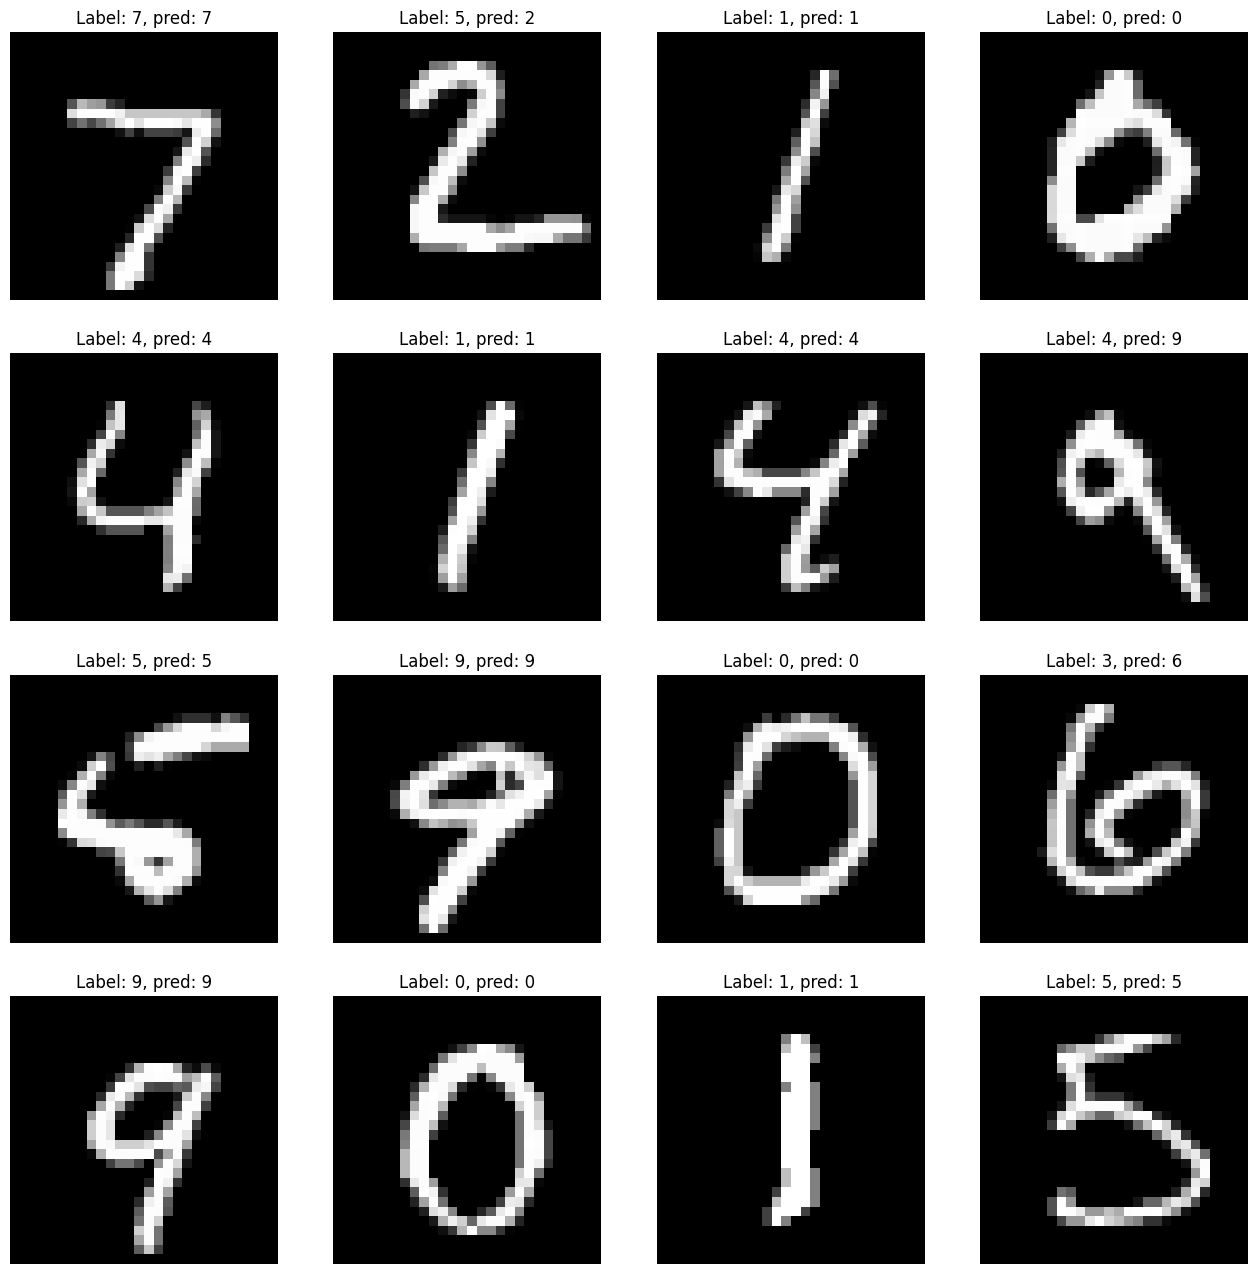

<Figure size 640x480 with 0 Axes>

In [54]:
test_loader_16 = DataLoader(test_set, shuffle=False, batch_size=16)
model.eval()
x, y = next(iter(test_loader_16))
_, pred = torch.max(model(x), 1)

titles = [f'Label: {l}, pred: {p}' for p,l in zip(y,pred)]
show_images(x, titles)

> Results are pretty good. The second image is wrongly classified. <br>
Two images other images are wrongly classified, however their label is not clear: a 4 that looks like a 9 and a 3 that looks like a 6. <br>

## Further experiments

1. Adapt the code to apply the ViT model on CIFAR dataset.
2. Make use of a validation set to evaluate overfitting.
3. Evaluate the model with a dimension of 16 for the tokens and 4 encoder blocks.

#### 1./2. Application on CIFAR dataset
> The CIFAR dataset contains 60.000 images. <br>
> First I will create the following sets: <br>
>> train set of 48000 images (80%) <br> 
>> validation set of 6000 images (10%) <br> 
>> test set of 6000 images (10%) <br>

In [9]:
num_workers = 0
batch_size = 128
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


In [10]:
dataloaders = {'train': train_loader,
              'val': valid_loader,
              'test': test_loader}

dataset_sizes = {'train': len(train_idx), 'val': len(valid_idx), 'test': len(test_data)}
print(dataset_sizes)

{'train': 40000, 'val': 10000, 'test': 10000}


#### Training with evaluation on validation dataset

In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, device='cuda:0'):
    print(f'training model')
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        if scheduler:
            scheduler.step()
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                training_losses.append(epoch_loss)
                training_accuracies.append(epoch_acc.item())
            elif phase == 'val':
                validation_losses.append(epoch_loss)
                validation_accuracies.append(epoch_acc.item())

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time, training_losses, training_accuracies, validation_losses, validation_accuracies

> CIFAR images have shapes 3x32x32, so I use 8 patches so that the patch dimension remains 16 for a single channel.<br>
> Since there are three channels, I increase the hidden dimension to 24 (=3*8). <br>
> The rest of the code is left unchanged. <br>

> Concerning the hyperparameters, a first training showed that the model learns, but very slowly (the accuracy increases by 0.05 at evert epoch) <br>
> Therefore I use a learning rate scheduler to speed up training, starting with a learning rate 5 times the value for the MNIST dataset. <br>
> I tried to use sgd optimizer with a 0.9 momentum and without learning rate scheduler, however the final accuracy was only 42%. <br>
> I also tried removing the scheduler with Adam optimizer, however the final accuracy was also lower. <br> 
> I also experimented with various values of learning rate. the value 0.01 as initial learning rate yields the best result. <br>

> The final validation accuracy of 50% is not that bad, considering the 10% we got with the MLP. <br>

In [57]:
cifar_model = ViT(
    (3, 32, 32), n_patches=8, n_blocks=2, hidden_d=24, n_heads=2, out_d=10
).to(device='cuda:0')

N_EPOCHS = 30
LR = 0.01

optimizer = Adam(cifar_model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(cifar_model.parameters(), lr=LR, momentum=0.9)
optimizer.step()
scheduler = lr_scheduler.StepLR(optimizer, step_size=13, gamma=0.1)
criterion = CrossEntropyLoss()
trained_model, epoch_time, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(cifar_model, criterion, optimizer, scheduler, num_epochs=N_EPOCHS)

training model


  0%|                                                                                                                                 | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
train Loss: 2.1864 Acc: 0.2597


  3%|████                                                                                                                     | 1/30 [01:15<36:15, 75.01s/it]

val Loss: 2.1424 Acc: 0.3040

Epoch 2/30
----------
train Loss: 2.1290 Acc: 0.3226


  7%|████████                                                                                                                 | 2/30 [02:30<35:00, 75.02s/it]

val Loss: 2.0988 Acc: 0.3536

Epoch 3/30
----------
train Loss: 2.1021 Acc: 0.3488


 10%|████████████                                                                                                             | 3/30 [03:45<33:46, 75.06s/it]

val Loss: 2.1177 Acc: 0.3312

Epoch 4/30
----------
train Loss: 2.0840 Acc: 0.3684


 13%|████████████████▏                                                                                                        | 4/30 [05:00<32:31, 75.04s/it]

val Loss: 2.0670 Acc: 0.3879

Epoch 5/30
----------
train Loss: 2.0667 Acc: 0.3855


 17%|████████████████████▏                                                                                                    | 5/30 [06:15<31:15, 75.01s/it]

val Loss: 2.0698 Acc: 0.3817

Epoch 6/30
----------
train Loss: 2.0674 Acc: 0.3857


 20%|████████████████████████▏                                                                                                | 6/30 [07:30<29:59, 74.97s/it]

val Loss: 2.0377 Acc: 0.4159

Epoch 7/30
----------
train Loss: 2.0473 Acc: 0.4069


 23%|████████████████████████████▏                                                                                            | 7/30 [08:45<28:45, 75.02s/it]

val Loss: 2.0395 Acc: 0.4176

Epoch 8/30
----------
train Loss: 2.0498 Acc: 0.4042


 27%|████████████████████████████████▎                                                                                        | 8/30 [10:00<27:30, 75.01s/it]

val Loss: 2.0372 Acc: 0.4191

Epoch 9/30
----------
train Loss: 2.0423 Acc: 0.4121


 30%|████████████████████████████████████▎                                                                                    | 9/30 [11:15<26:14, 74.98s/it]

val Loss: 2.0160 Acc: 0.4394

Epoch 10/30
----------
train Loss: 2.0356 Acc: 0.4191


 33%|████████████████████████████████████████                                                                                | 10/30 [12:30<24:59, 74.98s/it]

val Loss: 2.0425 Acc: 0.4121

Epoch 11/30
----------
train Loss: 2.0354 Acc: 0.4196


 37%|████████████████████████████████████████████                                                                            | 11/30 [13:45<23:45, 75.04s/it]

val Loss: 2.0135 Acc: 0.4419

Epoch 12/30
----------
train Loss: 2.0232 Acc: 0.4308


 40%|████████████████████████████████████████████████                                                                        | 12/30 [15:00<22:32, 75.13s/it]

val Loss: 2.0356 Acc: 0.4185

Epoch 13/30
----------
train Loss: 1.9844 Acc: 0.4732


 43%|████████████████████████████████████████████████████                                                                    | 13/30 [16:15<21:16, 75.11s/it]

val Loss: 1.9775 Acc: 0.4797

Epoch 14/30
----------
train Loss: 1.9713 Acc: 0.4861


 47%|████████████████████████████████████████████████████████                                                                | 14/30 [17:30<20:00, 75.06s/it]

val Loss: 1.9700 Acc: 0.4870

Epoch 15/30
----------
train Loss: 1.9654 Acc: 0.4932


 50%|████████████████████████████████████████████████████████████                                                            | 15/30 [18:45<18:46, 75.11s/it]

val Loss: 1.9710 Acc: 0.4838

Epoch 16/30
----------
train Loss: 1.9613 Acc: 0.4964


 53%|████████████████████████████████████████████████████████████████                                                        | 16/30 [20:00<17:31, 75.11s/it]

val Loss: 1.9647 Acc: 0.4906

Epoch 17/30
----------
train Loss: 1.9575 Acc: 0.5013


 57%|████████████████████████████████████████████████████████████████████                                                    | 17/30 [21:15<16:15, 75.05s/it]

val Loss: 1.9667 Acc: 0.4906

Epoch 18/30
----------
train Loss: 1.9528 Acc: 0.5062


 60%|████████████████████████████████████████████████████████████████████████                                                | 18/30 [22:30<15:00, 75.01s/it]

val Loss: 1.9640 Acc: 0.4941

Epoch 19/30
----------
train Loss: 1.9503 Acc: 0.5081


 63%|████████████████████████████████████████████████████████████████████████████                                            | 19/30 [23:45<13:45, 75.06s/it]

val Loss: 1.9637 Acc: 0.4919

Epoch 20/30
----------
train Loss: 1.9470 Acc: 0.5124


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 20/30 [25:00<12:30, 75.01s/it]

val Loss: 1.9603 Acc: 0.4982

Epoch 21/30
----------
train Loss: 1.9437 Acc: 0.5158


 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 21/30 [26:15<11:14, 74.98s/it]

val Loss: 1.9611 Acc: 0.4948

Epoch 22/30
----------
train Loss: 1.9419 Acc: 0.5176


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 22/30 [27:30<09:59, 74.95s/it]

val Loss: 1.9624 Acc: 0.4924

Epoch 23/30
----------
train Loss: 1.9386 Acc: 0.5213


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 23/30 [28:45<08:44, 74.99s/it]

val Loss: 1.9574 Acc: 0.4991

Epoch 24/30
----------
train Loss: 1.9365 Acc: 0.5234


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 24/30 [30:00<07:30, 75.00s/it]

val Loss: 1.9551 Acc: 0.5019

Epoch 25/30
----------
train Loss: 1.9349 Acc: 0.5261


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 25/30 [31:15<06:15, 75.03s/it]

val Loss: 1.9558 Acc: 0.4993

Epoch 26/30
----------
train Loss: 1.9256 Acc: 0.5369


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 26/30 [32:30<05:00, 75.03s/it]

val Loss: 1.9533 Acc: 0.5027

Epoch 27/30
----------
train Loss: 1.9239 Acc: 0.5388


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 27/30 [33:45<03:45, 75.03s/it]

val Loss: 1.9526 Acc: 0.5036

Epoch 28/30
----------
train Loss: 1.9234 Acc: 0.5399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28/30 [35:01<02:30, 75.10s/it]

val Loss: 1.9526 Acc: 0.5019

Epoch 29/30
----------
train Loss: 1.9228 Acc: 0.5404


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29/30 [36:16<01:15, 75.07s/it]

val Loss: 1.9528 Acc: 0.5018

Epoch 30/30
----------
train Loss: 1.9224 Acc: 0.5415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [37:30<00:00, 75.03s/it]

val Loss: 1.9526 Acc: 0.5032

Training complete in 37m 31s
Best val Acc: 0.503600


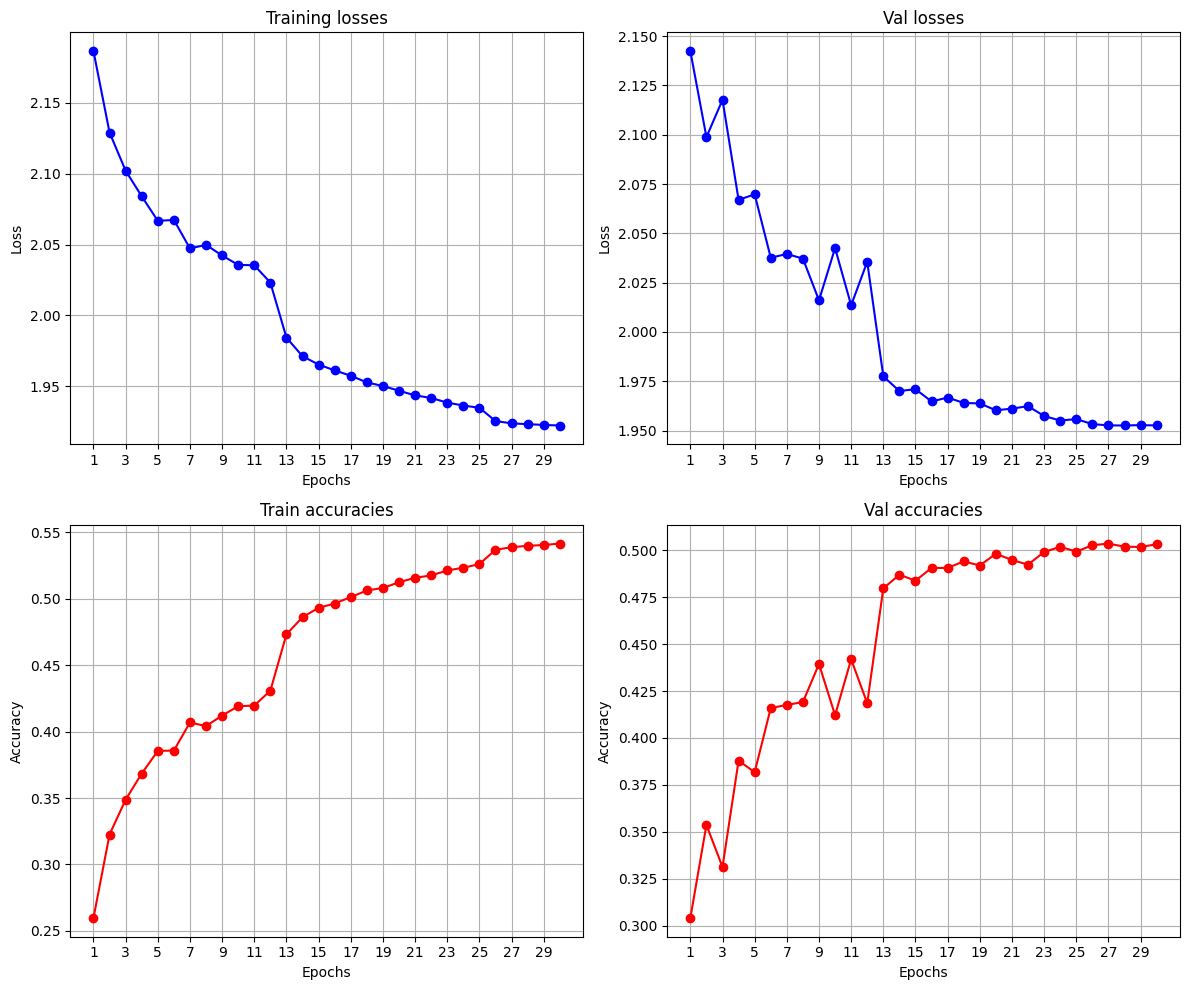

<Figure size 640x480 with 0 Axes>

In [70]:
def plot_results(N_EPOCHS, train_losses, train_accuracies, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 10))

    ax1[0].plot(range(1,N_EPOCHS+1), train_losses, marker='o', linestyle='-', color='b')
    ax1[0].set_title('Training losses')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].set_xticks(np.arange(1,N_EPOCHS+1,2))
    ax1[0].grid(True)

    ax2[0].plot(range(1,N_EPOCHS+1), train_accuracies, marker='o', linestyle='-', color='r')
    ax2[0].set_title('Train accuracies')
    ax2[0].set_xlabel('Epochs')
    ax2[0].set_ylabel('Accuracy')
    ax2[0].set_xticks(np.arange(1,N_EPOCHS+1,2))
    ax2[0].grid(True)

    ax1[1].plot(range(1,N_EPOCHS+1), val_losses, marker='o', linestyle='-', color='b')
    ax1[1].set_title('Val losses')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Loss')
    ax1[1].set_xticks(np.arange(1,N_EPOCHS+1,2))
    ax1[1].grid(True)

    ax2[1].plot(range(1,N_EPOCHS+1), val_accuracies, marker='o', linestyle='-', color='r')
    ax2[1].set_title('Val accuracies')
    ax2[1].set_xlabel('Epochs')
    ax2[1].set_ylabel('Accuracy')
    ax2[1].set_xticks(np.arange(1,N_EPOCHS+1,2))
    ax2[1].grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()  
    plt.savefig('two_heads_metrics.png')

plot_results(N_EPOCHS, training_losses, training_accuracies, validation_losses, validation_accuracies)

In [80]:
def test_model(model, train_on_gpu=True):
    test_loss = 0.0
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    for data, labels in dataloaders['test']:
        if train_on_gpu:
            data, labels = data.cuda(), labels.cuda()
        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = (
            np.squeeze(correct_tensor.numpy())
            if not train_on_gpu
            else np.squeeze(correct_tensor.cpu().numpy())
        )
        for i in range(len(labels)):
            class_correct[labels[i]] += correct[i].item()
            class_total[labels[i]] += 1

    # average test loss
    test_loss = test_loss / len(dataloaders['test'])
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print(
                "Test Accuracy of %5s: %2d%% (%2d/%2d)"
                % (
                    classes[i],
                    100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]),
                    np.sum(class_total[i]),
                )
            )
        else:
            print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

    print(
        "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
        % (
            100.0 * np.sum(class_correct) / np.sum(class_total),
            np.sum(class_correct),
            np.sum(class_total),
        )
    )

    return np.sum(class_correct) / np.sum(class_total), test_loss

#### 3. Dimension 16 for the token an 4 heads

I use the same hyperparameters I used for the first version.

In [ ]:
cifar_model_2 = ViT(
    (3, 32, 32), n_patches=8, n_blocks=2, hidden_d=16, n_heads=4, out_d=10
).to(device='cuda:0')

N_EPOCHS = 30
LR = 0.01

optimizer = Adam(cifar_model.parameters(), lr=LR)
optimizer.step()
scheduler = lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
criterion = CrossEntropyLoss()
trained_model, epoch_time, training_losses, training_accuracies, validation_losses, validation_accuracies = train_model(cifar_model, criterion, optimizer, scheduler, num_epochs=N_EPOCHS)

> Results are a bit better with 4 heads and a hidden dimension of 16, with the best validation accuracy around 53%. <br>
> It is interesting to see the gap when the learning rate scheduler divides by 10 the learning rate between epoch 11 and epoch 12. <br>
 It shows the importance of decreasing the learning rate when the model has reached a local minima with a given learning rate.

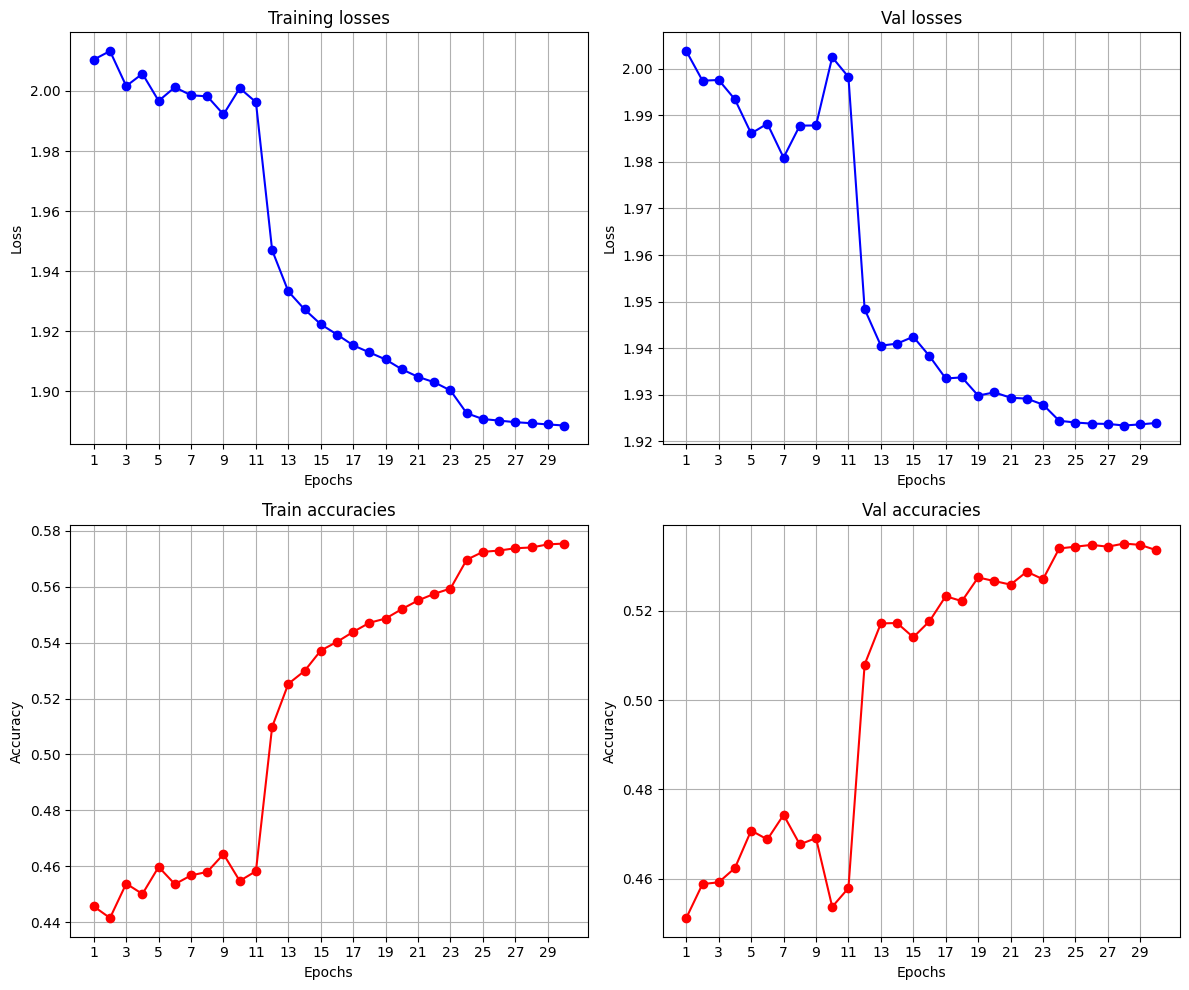

<Figure size 640x480 with 0 Axes>

In [73]:
plot_results(N_EPOCHS, training_losses, training_accuracies, validation_losses, validation_accuracies)

> I didn't test the model for the first version, but I do it now with the improved 4-heads version.

In [81]:
test_model(trained_model)

Test Loss: 245.256953

Test Accuracy of airplane: 55% (554/1000)
Test Accuracy of automobile: 63% (637/1000)
Test Accuracy of  bird: 33% (335/1000)
Test Accuracy of   cat: 34% (347/1000)
Test Accuracy of  deer: 38% (385/1000)
Test Accuracy of   dog: 45% (455/1000)
Test Accuracy of  frog: 63% (630/1000)
Test Accuracy of horse: 58% (580/1000)
Test Accuracy of  ship: 70% (704/1000)
Test Accuracy of truck: 56% (563/1000)

Test Accuracy (Overall): 51% (5190/10000)


(0.519, 245.2569526479214)

> The test accuracy is slightly lower than the validation accuracy. <br>
> The accuracy is very variable accross classes, from 33% (birds) to 70% (ships). <br>
> Overall the results are not that bad since the model was implemented from scratch using principles from the attention paper. <br>
> In particular, the positional constant in the cos and sin functions of the positoinal embedding is probably not adapted to our small imges, because the vectors are smaller than the ones in the paper. <br>
> We probably need to train the model for additional epochs, 30 is probably not enough. <br>
> More data could be beneficial as well: ViT-H was trained with the 10 million images from ImageNet, not just 48.000. <br>